In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as torch_d
import tikzplotlib

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
class Receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y

class Receiver2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(128, 128)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(128, M)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)


class Encoder2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, 128)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(128, M)

    def forward(self, y):
        y = self.act1(self.lin1(y))
        return self.lin2(y)

class Encoder(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M, bias=False)
        nn.init.constant_(self.lin1.weight, 1 / M)

    def forward(self, y):
        return self.lin1(y)

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return nn.functional.one_hot(torch.argmax(input, dim=-1), 8).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [4]:
def gradient_correction_factor(app, idx, prob, M):
    (nn,M)= app.shape
    cf  = torch.zeros(M)
    for j in range(M):
        tmp = app[:, j]
        cf[j] = torch.sum(torch.log(tmp[idx==j])) / (nn*prob[j]) # tmp[idx==j] selects the ll of those xy pairs which belong to the current symbol j
    return cf

In [5]:
def AWGN_channel(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return x + noise_t

In [6]:
M = 8
n = 10_000
nepochs = 2000
lr = 0.01

alphabet = np.arange(-(M-1),M,2)
# alphabet = np.array([-7, -3, -2, -1, 1, 2, 3, 7])
#alphabet = np.array([-10, -6, -3, -1, 1, 3, 6, 10]) <-- Non-uniform alphabet
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
alphabet_t = torch.tensor(alphabet).float()

In [7]:
def sampler(logits, n, M):
    temperature = 10
    estimator = STEFunction.apply
    g_dist = torch_d.Gumbel(loc=torch.tensor([0.]), scale=torch.tensor([1.])) # create Gumbel dist
    g = g_dist.sample(sample_shape=[n, M]).squeeze()
    s_bar = nn.functional.softmax(input=((g + logits) / temperature), dim=1)
    s = estimator(s_bar) # straight through estimator
    return s

dec = Receiver2(M)
enc = Encoder2(M)
loss_fn = nn.CrossEntropyLoss()

def train_encoder_at_dB(dB, report=False):
    SNR_dB = dB
    SNR = 10**(SNR_dB/10)
    sigma2 = 1/SNR

    opt = optim.Adam( list(enc.parameters()) + list(dec.parameters()), lr=lr)

    for j in range(nepochs):
        logits = enc(torch.tensor([1], dtype=torch.float))

        # Sample indexes
        # onehot = sampler(probs, n, M)
        onehot = nn.functional.gumbel_softmax(logits.expand(n, -1), tau=10, hard=True)
        indices = torch.argmax(onehot, dim=1)

        # Modulation
        # with torch.no_grad():
        probs =  nn.functional.softmax(logits, -1)
        norm_factor = torch.rsqrt(torch.sum(torch.pow(torch.abs(alphabet_t), 2) * probs))
        alphabet_norm =  alphabet_t * norm_factor
        symbols = torch.matmul(onehot, torch.transpose(input=alphabet_norm.reshape(1,-1), dim0=0, dim1=1))

        # Channel
        y = AWGN_channel(symbols, sigma2)

        # Demodulator
        ll = dec(y.reshape(-1,1))
        # app = nn.functional.softmax(ll, 1) #Q(X|Y)

        # Loss
        loss = -(torch.sum(-probs*torch.log(probs)) - loss_fn(ll, indices.detach()))# -(H(X) - CE(P,Q)), the gradient descent minimizes, therefore we minimize the opposite to maximize the MI in the end.
        opt.zero_grad()
        loss.backward()

        opt.step()

        # Printout and visualization
        if report and j % 500 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f}')

    if report:
        print('probs: ', probs)
        plt.hist(symbols.detach().numpy(), bins=100)
        plt.show()

    return loss

### Compare Results

In [8]:
def AWGN_channel_np(x, sigma2):
    noise = np.sqrt(sigma2) * np.random.randn(x.size)
    return x + noise

In [9]:
def AWGNdemapper(y, const, varN):
    apps = np.exp(-np.abs(np.transpose([y])-const)**2/(2*varN))
    return apps / np.transpose([np.sum(apps, 1)])

In [10]:
def xesmd(apps, idx):
    """
    Estimates symbolwise equivocation from reference symbols indices and a posteriori probabilities.
    """
    eq = -np.log(np.take_along_axis(apps, idx[:, None], axis=1) / np.transpose([np.sum(apps, 1)]))
    eq[eq==np.inf] = 1000
    return np.mean(eq)

SNR:  5
epoch 0: Loss = 0.0435
epoch 500: Loss = -0.9978
epoch 1000: Loss = -1.0176
epoch 1500: Loss = -1.0103
probs:  tensor([0.0493, 0.0981, 0.1558, 0.1967, 0.1965, 0.1565, 0.0976, 0.0493],
       grad_fn=<SoftmaxBackward0>)


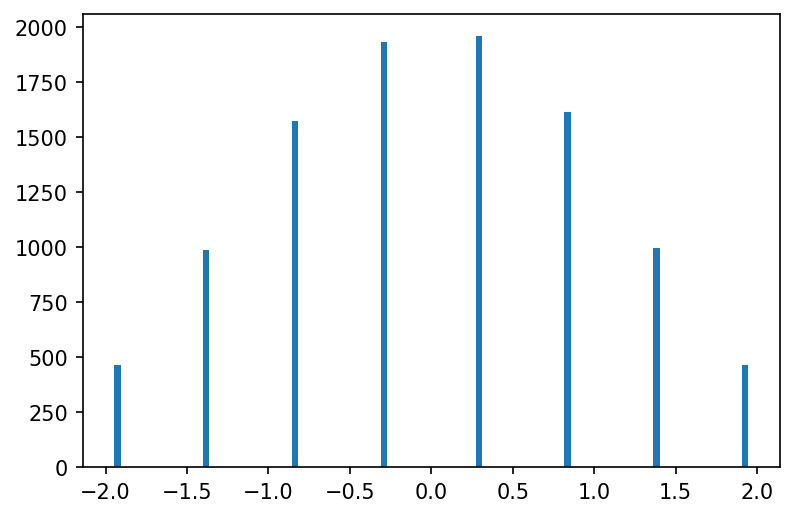

SNR:  6
epoch 0: Loss = -1.1350
epoch 500: Loss = -1.1557
epoch 1000: Loss = -1.1409
epoch 1500: Loss = -1.1584
probs:  tensor([0.0457, 0.0958, 0.1588, 0.2008, 0.2011, 0.1554, 0.0964, 0.0460],
       grad_fn=<SoftmaxBackward0>)


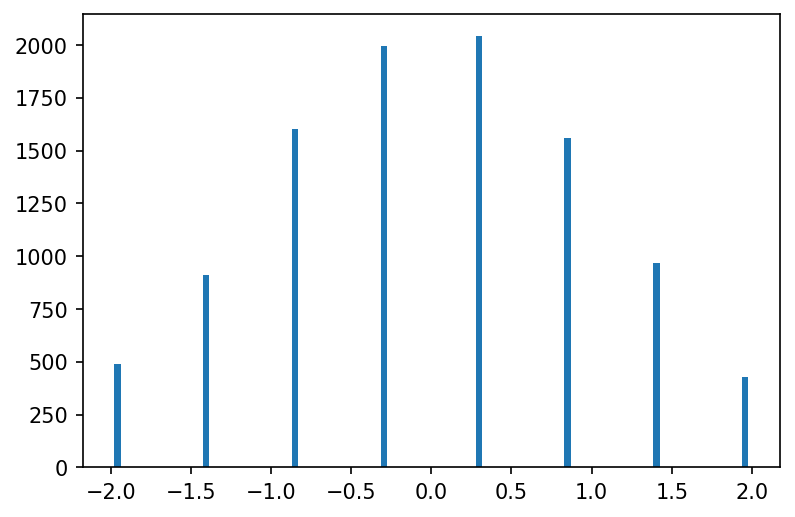

SNR:  7
epoch 0: Loss = -1.2862
epoch 500: Loss = -1.2821
epoch 1000: Loss = -1.2971
epoch 1500: Loss = -1.2653
probs:  tensor([0.0379, 0.0903, 0.1593, 0.2131, 0.2128, 0.1598, 0.0890, 0.0378],
       grad_fn=<SoftmaxBackward0>)


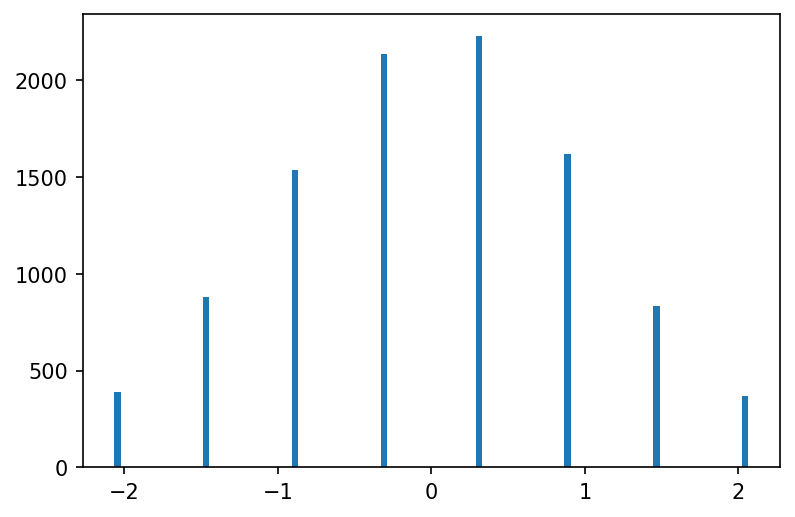

SNR:  8
epoch 0: Loss = -1.4176
epoch 500: Loss = -1.4383
epoch 1000: Loss = -1.4388
epoch 1500: Loss = -1.4111
probs:  tensor([0.0355, 0.0878, 0.1603, 0.2166, 0.2167, 0.1601, 0.0876, 0.0354],
       grad_fn=<SoftmaxBackward0>)


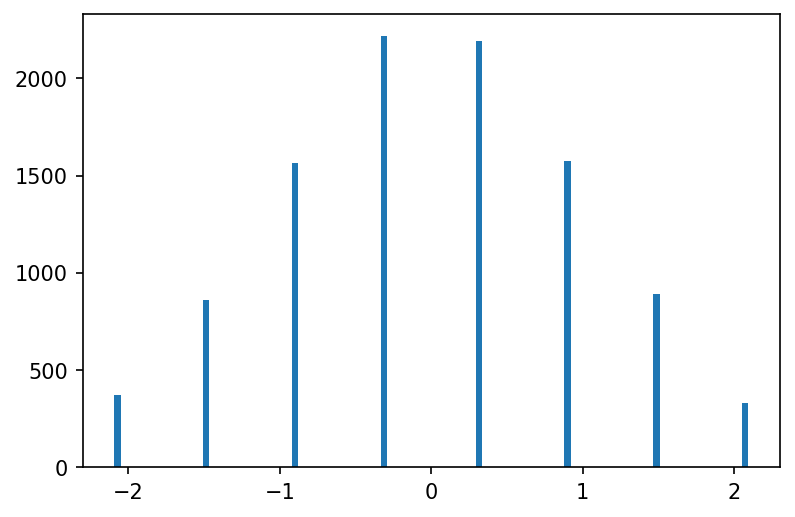

SNR:  9
epoch 0: Loss = -1.5581
epoch 500: Loss = -1.5638
epoch 1000: Loss = -1.5842
epoch 1500: Loss = -1.5651
probs:  tensor([0.0306, 0.0826, 0.1593, 0.2249, 0.2251, 0.1634, 0.0832, 0.0308],
       grad_fn=<SoftmaxBackward0>)


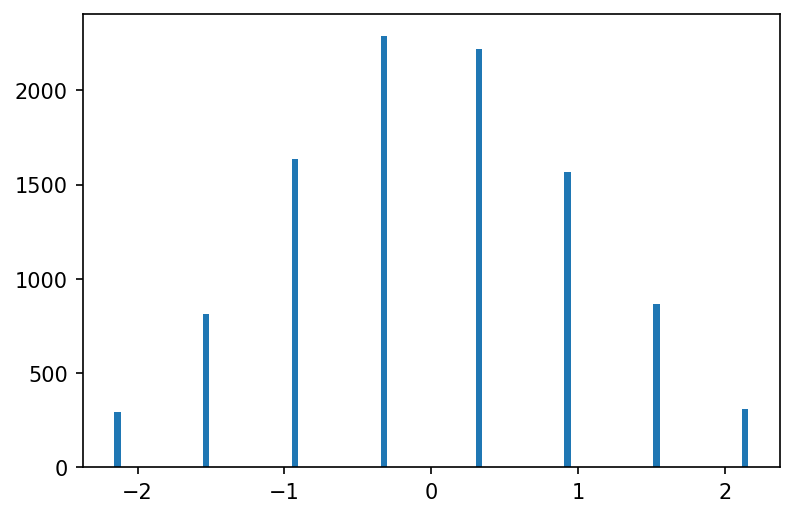

SNR:  10
epoch 0: Loss = -1.6800
epoch 500: Loss = -1.7316
epoch 1000: Loss = -1.7230
epoch 1500: Loss = -1.7159
probs:  tensor([0.0265, 0.0784, 0.1602, 0.2330, 0.2331, 0.1638, 0.0784, 0.0266],
       grad_fn=<SoftmaxBackward0>)


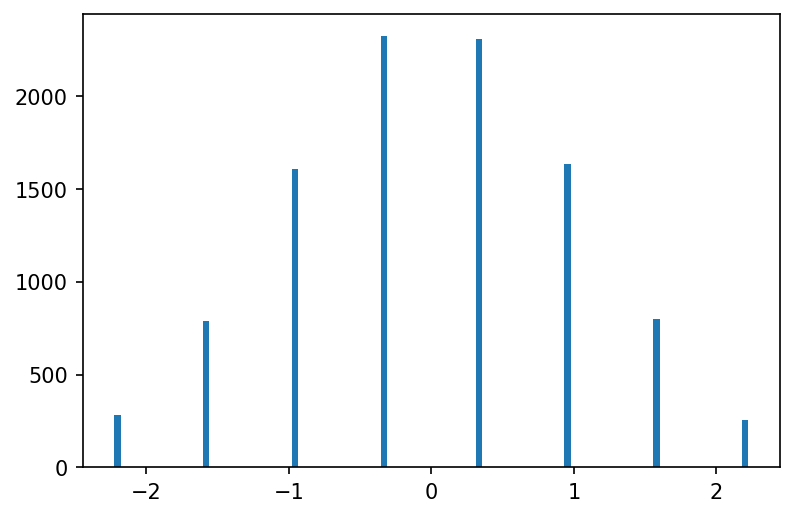

SNR:  11
epoch 0: Loss = -1.8435
epoch 500: Loss = -1.8771
epoch 1000: Loss = -1.8751
epoch 1500: Loss = -1.8712
probs:  tensor([0.0257, 0.0774, 0.1618, 0.2347, 0.2348, 0.1625, 0.0775, 0.0257],
       grad_fn=<SoftmaxBackward0>)


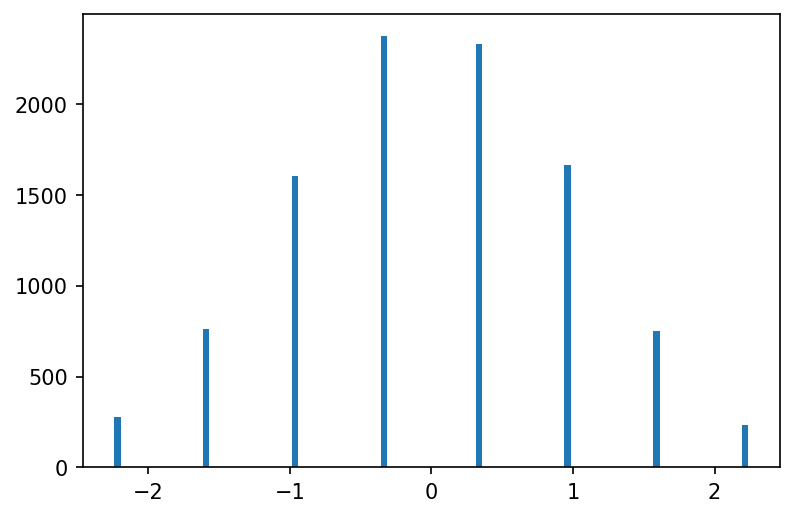

SNR:  12
epoch 0: Loss = -2.0034
epoch 500: Loss = -2.0237
epoch 1000: Loss = -2.0088
epoch 1500: Loss = -2.0142
probs:  tensor([0.0269, 0.0787, 0.1618, 0.2324, 0.2324, 0.1622, 0.0787, 0.0269],
       grad_fn=<SoftmaxBackward0>)


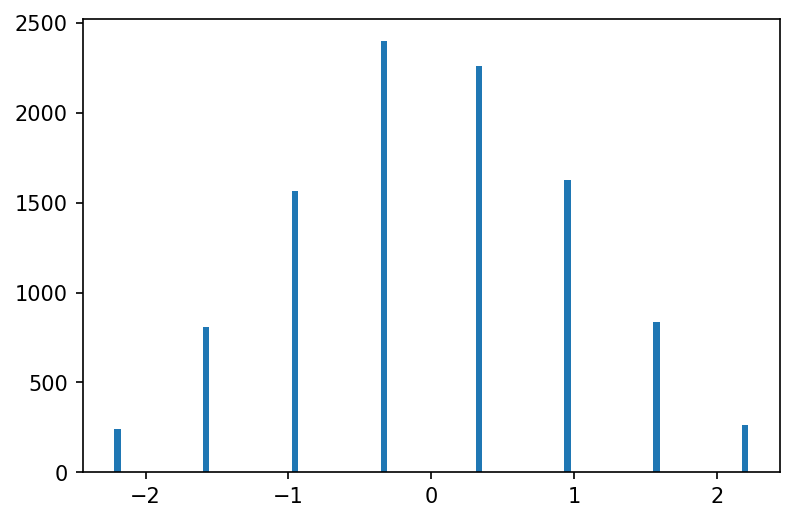

SNR:  13
epoch 0: Loss = -2.1438
epoch 500: Loss = -2.1613
epoch 1000: Loss = -2.1538
epoch 1500: Loss = -2.1674
probs:  tensor([0.0312, 0.0832, 0.1610, 0.2242, 0.2243, 0.1615, 0.0833, 0.0313],
       grad_fn=<SoftmaxBackward0>)


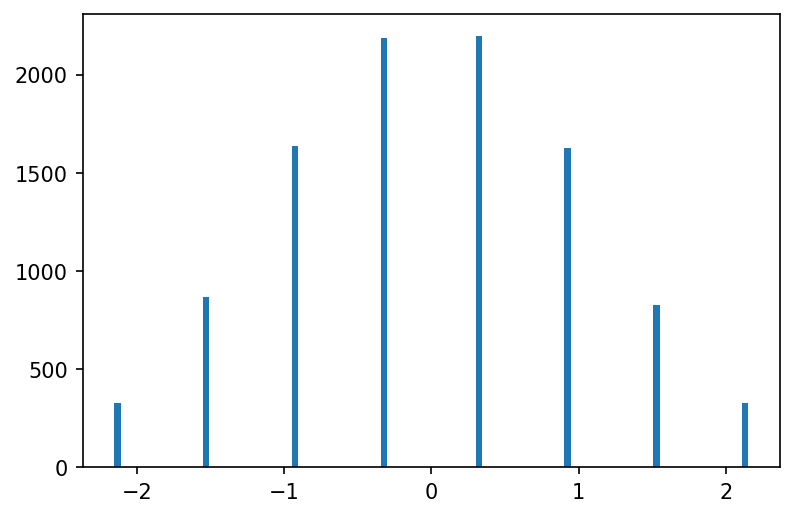

SNR:  14
epoch 0: Loss = -2.2992
epoch 500: Loss = -2.3009
epoch 1000: Loss = -2.3015
epoch 1500: Loss = -2.2925
probs:  tensor([0.0374, 0.0891, 0.1598, 0.2139, 0.2139, 0.1596, 0.0891, 0.0373],
       grad_fn=<SoftmaxBackward0>)


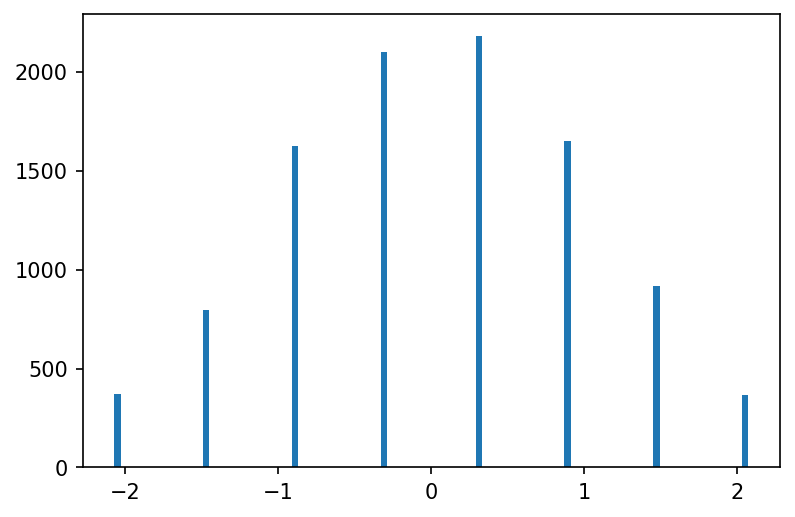

SNR:  15
epoch 0: Loss = -2.4422
epoch 500: Loss = -2.4560
epoch 1000: Loss = -2.4311
epoch 1500: Loss = -2.4574
probs:  tensor([0.0455, 0.0956, 0.1570, 0.2017, 0.2017, 0.1573, 0.0956, 0.0456],
       grad_fn=<SoftmaxBackward0>)


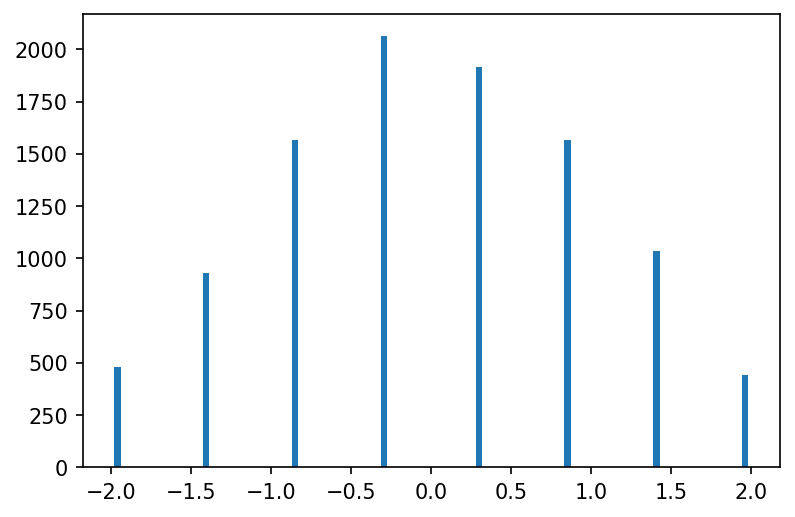

SNR:  16
epoch 0: Loss = -2.5451
epoch 500: Loss = -2.5761
epoch 1000: Loss = -2.5792
epoch 1500: Loss = -2.5584
probs:  tensor([0.0552, 0.1015, 0.1542, 0.1894, 0.1894, 0.1538, 0.1014, 0.0551],
       grad_fn=<SoftmaxBackward0>)


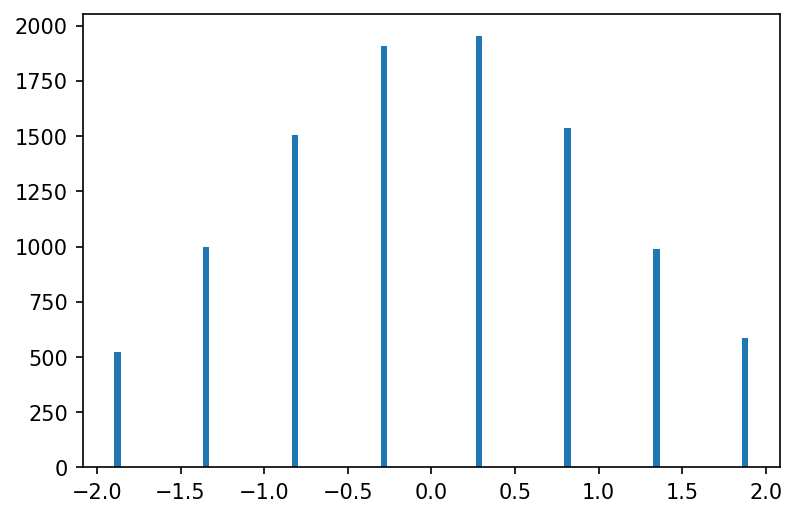

SNR:  17
epoch 0: Loss = -2.6668
epoch 500: Loss = -2.6879
epoch 1000: Loss = -2.6699
epoch 1500: Loss = -2.6844
probs:  tensor([0.0654, 0.1072, 0.1499, 0.1773, 0.1773, 0.1500, 0.1074, 0.0654],
       grad_fn=<SoftmaxBackward0>)


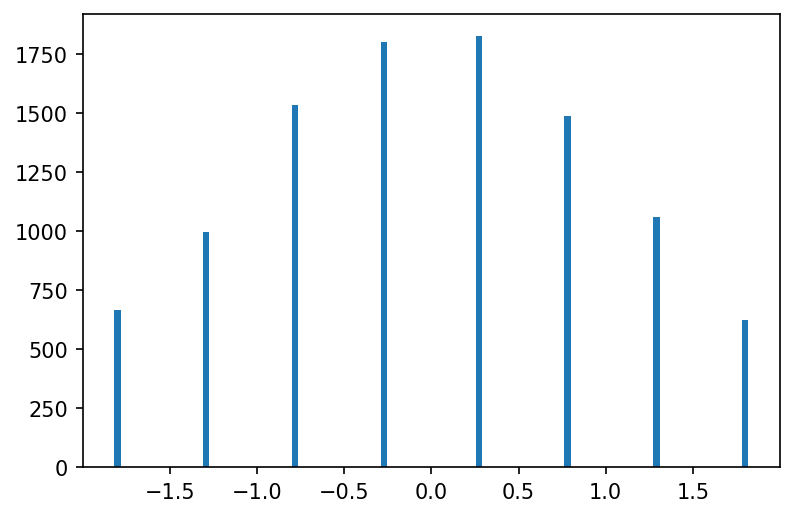

SNR:  18
epoch 0: Loss = -2.7687
epoch 500: Loss = -2.7787
epoch 1000: Loss = -2.7802
epoch 1500: Loss = -2.7670
probs:  tensor([0.0767, 0.1123, 0.1455, 0.1655, 0.1655, 0.1455, 0.1122, 0.0767],
       grad_fn=<SoftmaxBackward0>)


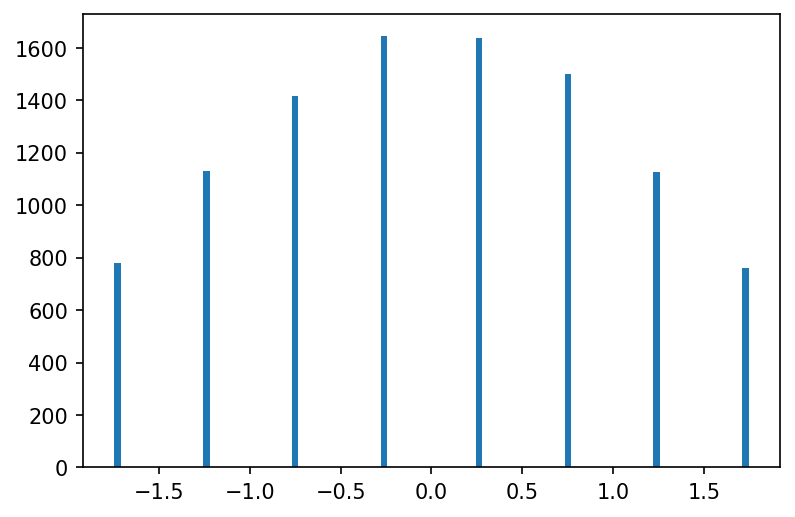

SNR:  19
epoch 0: Loss = -2.8394
epoch 500: Loss = -2.8588
epoch 1000: Loss = -2.8462
epoch 1500: Loss = -2.8580
probs:  tensor([0.0883, 0.1167, 0.1408, 0.1546, 0.1545, 0.1405, 0.1164, 0.0882],
       grad_fn=<SoftmaxBackward0>)


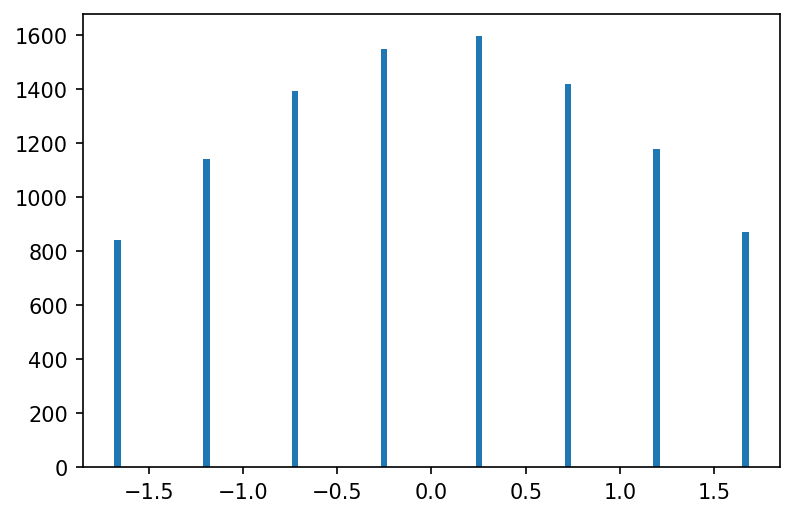

SNR:  20
epoch 0: Loss = -2.9111
epoch 500: Loss = -2.9111
epoch 1000: Loss = -2.9131
epoch 1500: Loss = -2.9163
probs:  tensor([0.0987, 0.1200, 0.1359, 0.1452, 0.1452, 0.1360, 0.1202, 0.0988],
       grad_fn=<SoftmaxBackward0>)


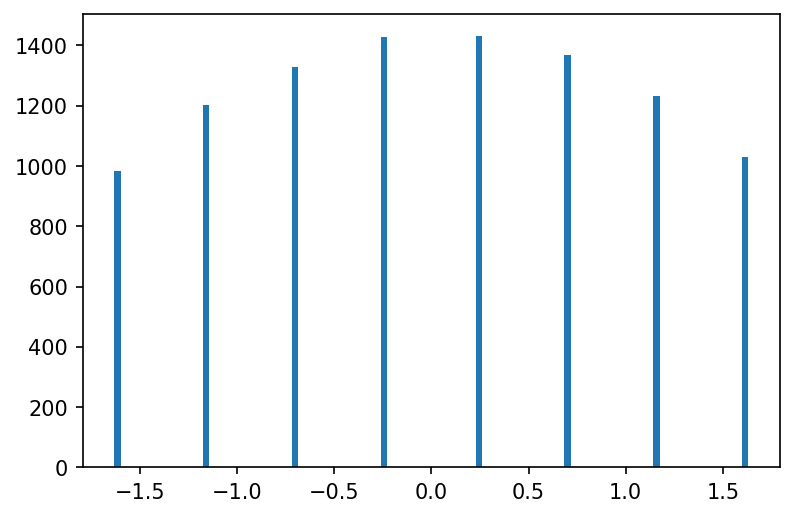

SNR:  21
epoch 0: Loss = -2.9527
epoch 500: Loss = -2.9537
epoch 1000: Loss = -2.9527
epoch 1500: Loss = -2.9494
probs:  tensor([0.1089, 0.1221, 0.1318, 0.1371, 0.1371, 0.1318, 0.1223, 0.1090],
       grad_fn=<SoftmaxBackward0>)


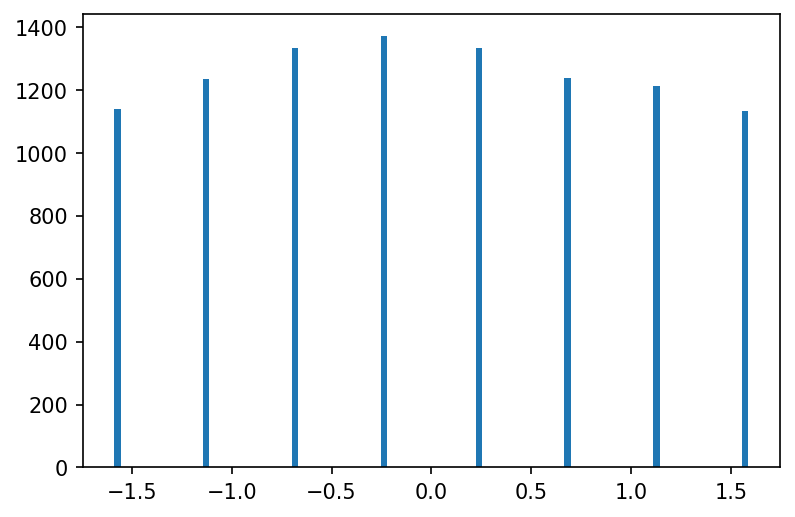

In [11]:
n = 10_000
SNR_dBs = np.arange(5,22)
M = 8
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols = alphabet[indices]

mi_64 = []
mi_pas = []
for snrdB in SNR_dBs:
    print('SNR: ', snrdB)
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2
    y = AWGN_channel_np(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_64.append(2*(3 - (xe) / np.log(2)))
    mi_pas.append(-2*(train_encoder_at_dB(snrdB, report=True)).detach().numpy().tolist()/np.log(2))

In [1]:
print(mi_64)

NameError: name 'mi_64' is not defined

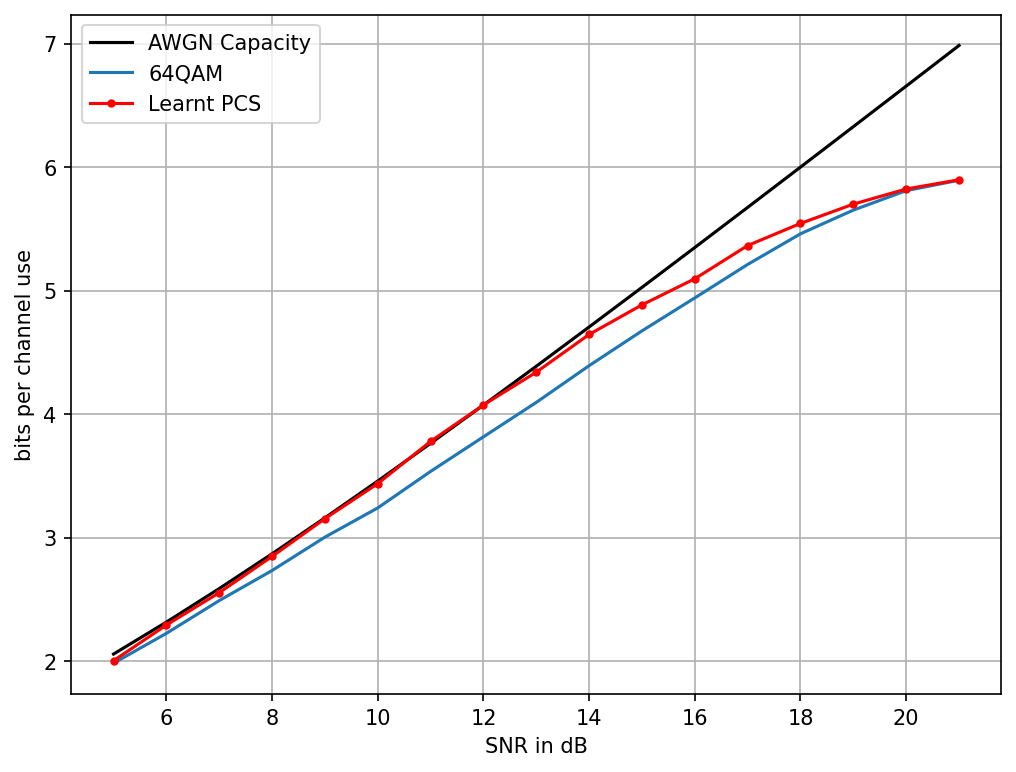

In [13]:
# Plot
plt.rcParams['figure.figsize'] = [8, 6]

plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='AWGN Capacity')
plt.plot(SNR_dBs, mi_64, label = '64QAM')

plt.plot(SNR_dBs, mi_pas, color='red', marker='o', markersize=3, label='Learnt PCS')
# for xy in zip(SNR_dBs, mi_pas):
#    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.legend()
plt.grid()
plt.ylabel('bits per channel use')
plt.xlabel('SNR in dB')
tikzplotlib.save("stark_tikz.tex")